In [134]:
import os 
import pandas as pd 
import plotly as py
import seaborn as sns 
import matplotlib.pyplot as plt

# set dir
os.chdir("C://Users//mandy//Desktop//DataForGood")

# Read in data 
data = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)

# Extract column names 
colnames = data.iloc[0,:]

data = data.iloc[1:,:]

# set seaborn style 
sns.set(style="whitegrid")

## Outlier Removal 

Outerliers can be due to: 
1. Errorenous input (someone deliberately/accidentally lied on the survey) 
2. Extreme examples (think the "Wayne Gretzsky" of data science)

In [66]:
""" Removing Potentially Erroraneous input """

# Remove responses that are completed under 30 seconds
# These respondants likely rushed through the survey without much thought (responses won't be as credible)
data["Time from Start to Finish (seconds)"] = data["Time from Start to Finish (seconds)"].apply(pd.to_numeric)
data = data[data["Time from Start to Finish (seconds)"] > 30]

# Remove logical inconsistencies
# Example: Remove respondants who claim to be unemployed and making more than a certain amount of money 

## Where do surveyors come from?

Plotting surveyor location on chlorepath map.

In [51]:
country_freq = data["Q3"].value_counts().reset_index()
country_freq.columns = ["country", "num respondants"]

# Obtain country codes for plotting 
# Note: examining the data tells us that not all countries are properly coded
# We can create a mapper to map names as they appear in the survey to the country names in the plotly dataset

mapper = {"United States of America": "United States",
          "Viet Nam": "Vietnam",
          "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
          "South Korea": "Korea, South",
          "Iran, Islamic Republic of...": "Iran",
          "Hong Kong (S.A.R.)": "Hong Kong",
          "Republic of Korea": "Korea, North"
         }

country_freq["country"] = country_freq["country"].apply(lambda x: mapper[x] if x in mapper.keys() else x)

codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

# Merge country codes with country names 
country_freq = pd.merge(country_freq, codes, how = "inner", left_on = ['country'], right_on = ['COUNTRY'])

# Plot respondants by country
api_key = "Redacted"
py.tools.set_credentials_file(username='happilyeverafter95',api_key=api_key)

country_plot = [ dict(
        type = 'choropleth',
        locations = country_freq['CODE'],
        z = country_freq["num respondants"],
        text = country_freq['COUNTRY'],
        colorscale = "Greens",
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Number of Responders'),
      ) ]

layout = dict(
    title = 'Responders by country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

# See plot at https://plot.ly/~happilyeverafter95/0
fig = dict( data=country_plot, layout=layout )
py.plotly.iplot(fig, validate=False, filename='d3-world-map')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~happilyeverafter95/0 or inside your plot.ly account where it is named 'd3-world-map'


## Level of Education for each Job

How "educated" do you need to be to be a data scientist? Data Engineer? Data Analyst?

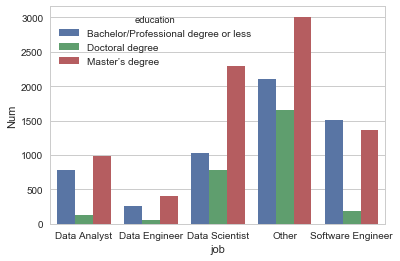

In [115]:
education = data[["Q4", "Q6"]].dropna(how = "any")
education.columns = ["education", "job"]

# Remove responses from students, unemployed individuals or people who chose not to answer
education = education[~education["job"].isin(["Student", "Not employed", "I prefer not to answer"])]
education = education[education["education"] != "I prefer not to answer"]

# Separate into Master's, Doctoral, Bachelor's/Professional degree or less 
education["education"] = education["education"].apply(lambda x: x if x in ["Doctoral degree", "Master’s degree"] else "Bachelor/Professional degree or less")

# Examine subset of careers
education["job"] = education["job"].apply(lambda x: x if x in ["Data Scientist", "Software Engineer", "Data Analyst", "Data Engineer"] else "Other")

education = education.groupby(["job", "education"]).size().reset_index()
education.columns = ["job", "education", "Num"]

ax = sns.barplot(x="job", y="Num", hue = "education",data=education)
ax.set(xlabel = "Job", ylabel = "# Respondants")

plt.show()

## Salary Variations between Jobs 

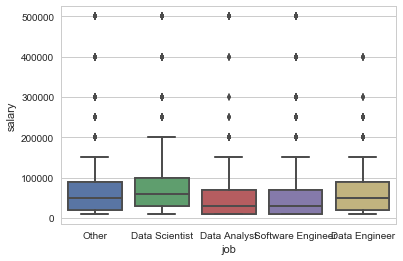

In [136]:
salary = data[["Q6", "Q9"]].dropna(how = "any")
salary.columns = ["job", "salary"]

# Remove respondants who are students, unemployed or wish not to disclose yearly compensation
salary = salary[~salary["job"].isin(["Student", "Not employed","I prefer not to answer"])]
salary = salary[salary["salary"] != "I do not wish to disclose my approximate yearly compensation"]

# Examine subset of careers
salary["job"] = salary["job"].apply(lambda x: x if x in ["Data Scientist", "Software Engineer", "Data Analyst", "Data Engineer"] else "Other")

# Map salary to upper limit
def map_salary(amt):
    amt = amt.split("-")
    if len(amt) == 2:
        amt = amt[1]
    else: 
        amt = amt[0]
    amt = [c for c in amt if c.isdigit()]
    amt = "".join(amt)
    return int(amt)

salary["salary"] = salary["salary"].apply(map_salary)
ax = sns.boxplot(x="job", y = "salary",data=salary)
ax.set(xlabel = "Job", ylabel = "Upper limit of Salary")

plt.show()

The range is very large for the previous salary chart. 

Let's remove some superstar observations and see if that gives us more insight.

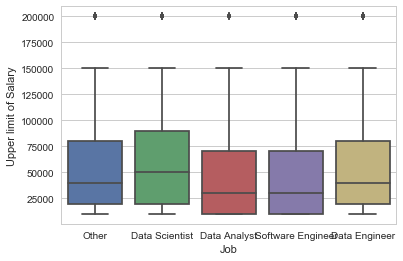

In [139]:
# Remove all responses where upper limit of salary > (mean + 3 standard deviation)

mean = salary["salary"].mean()
std = salary["salary"].std()

salary = salary[salary["salary"] <= mean + 3*std]

ax = sns.boxplot(x="job", y = "salary",data=salary)
ax.set(xlabel = "Job", ylabel = "Upper limit of Salary")

plt.show()

'C:\\Users\\mandy\\Desktop\\DataForGood'